In [1]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm

import pandas as pd

# Pytorch
import torch
torch.manual_seed(29)
from torch import nn
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.nn.parallel
cudnn.benchmark = True
import torchvision.transforms as transforms

from twrap.utils import model_summary, tensor_to_torch_var
from utils.models import *
from utils.stn_models import *
from torch.utils.data import DataLoader
from utils.datasets import dataset, dataset_nonvisob, TestSampler, test_dataset
from twrap.transform import ToZNorm

from twrap.utils import genROC

from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 12})

from glob import glob
from sklearn.metrics import roc_curve

from utils.model_utils import genRegionMask


transform=transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(160),
#     transforms.CenterCrop(160),
#     ToZNorm()
    transforms.ToTensor()
    ])


weights_dir = '/media/narsi/LargeData/SP2019/ocularnetv2.1/EX01/weights'

scores_list = [['device', 'visit', 'light_enroll', 'light_verify', 'eye', 'AUC', 'D-prime', 'EER', 'GMR@0.01FMR', 'GMR@0.001FMR']]


In [2]:
def dprime(targets, scores):
    
    Zt = scores[targets==1]
    Ztm = np.mean(Zt)
    Ztv = np.var(Zt)
    
    Zn = scores[targets==0]
    Znm = np.mean(Zn)
    Znv = np.var(Zn)
    
    d_1 = np.abs(Znm - Ztm)
    d_2 = (0.5 * (Ztv + Znv))**0.5
    
    return d_1/d_2

In [ ]:
model = MODEL8(400, classify = False, attention = True, illum_inv=True)
check_point_file = '/media/narsi/LargeData/SP2019/ocularnetv2.1/EX01/weights/MODEL8_VISOB.400.SUB_3x3Region_EXP01/model_best.pth.tar'
checkpoint = torch.load(check_point_file, map_location=lambda storage, loc: storage)
model.load_state_dict(checkpoint['state_dict'])

# check_point_file = '/home/narsi/Desktop/MODEL4_MITG_EXP01/model_best.pth.tar'
# model.regions = genRegionMask(w = 20, s1 = 13, s2 = 7, s3 = 7, s4 = 2)
# model.regions.data.requires_grad = False
model.cuda()
model.eval()
print('.')

In [3]:
model = STNMODEL_1(400, classify = False, attention = True, illum_inv=True)
check_point_file = '/home/narsi/local/ocularnetv2.1/weights/STNMODEL_1_VISOB.ALL.S1_EXP02/model_best.pth.tar'
checkpoint = torch.load(check_point_file, map_location=lambda storage, loc: storage)
model.load_state_dict(checkpoint['state_dict'])

# check_point_file = '/home/narsi/Desktop/MODEL4_MITG_EXP01/model_best.pth.tar'
# model.regions = genRegionMask(w = 20, s1 = 13, s2 = 7, s3 = 7, s4 = 2)
# model.regions.data.requires_grad = False
model.cuda()
model.eval()
print('.')

.


In [7]:
x = model.STN(I1)

In [8]:
x = x.cpu().view(-1, 2, 3).data.numpy()

In [54]:
I = np.float32(Image.open('/media/narsi/fast_drive/CCRops/ubirisv2/imgs/C23_S1_I7.tiff').convert('L').resize((160, 160), Image.BICUBIC))/255.0

In [55]:
I1 = torch.from_numpy(I).unsqueeze(0).unsqueeze(0).cuda()

In [56]:
X1 = model(I1)

In [11]:
from skimage.transform import AffineTransform, warp, ProjectiveTransform

In [6]:
X = AT(scale = (1.0, 1.0), rotation=0.5, translation=(10, 100))

In [12]:
matrix = np.array([[ 2.441415  ,  0.03468987, -1.4408023 * 160], 
                   [-0.07431868,  2.1263165 ,  1.3620533 * 160],
                   [0, 0, 1]])
warped = warp(I, matrix)
#warped = warp(I, ProjectiveTransform(matrix=matrix))

In [33]:
from skimage.transform import resize

(-0.5, 159.5, 159.5, -0.5)

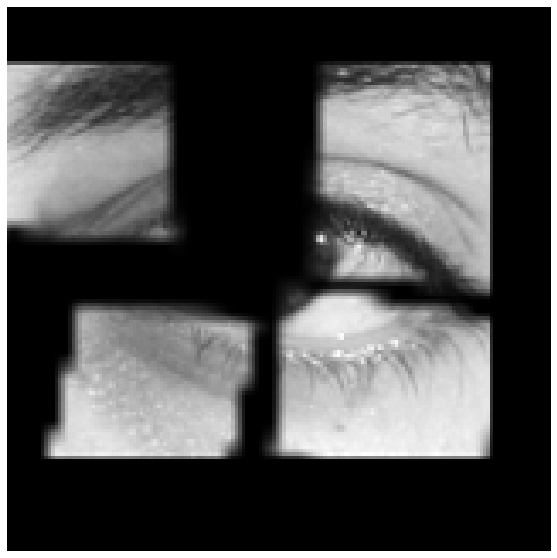

In [57]:
plt.figure(figsize=(10, 10))
Z = I * 0.0
for i in range(4):
    x = X1[1].cpu().data.numpy()[0, i, 0, ...]
    x = resize(x, (160, 160))
    Z += x * I
# plt.subplot(2, 2, i+1)
plt.imshow(Z, cmap = 'gray')#x * I
plt.axis('off')

In [16]:
src_fldr = '/media/narsi/fast_drive/CCRops/ubipr/imgs'

e_dataset = dataset_nonvisob(src_fldr, img_type = '*_D1*.bmp', transform = transform)
v_dataset = dataset_nonvisob(src_fldr, img_type = '*_D5*.bmp', transform = transform)

dataset_loader = DataLoader(e_dataset, num_workers=8, pin_memory=True, batch_sampler = TestSampler(len(e_dataset), 128))
e_feat = []
e_labels = []

for (batch_data, batch_target) in tqdm(dataset_loader):

    input_var = tensor_to_torch_var(batch_data, True)
    e_feat.append(model(input_var)[0].data.cpu())
    e_labels += batch_target
    del input_var

e_feat = torch.cat(e_feat, dim = 0)
e_labels = np.asarray(e_labels, dtype = np.object)

dataset_loader = DataLoader(v_dataset, num_workers=8, pin_memory=True, batch_sampler = TestSampler(len(v_dataset), 128))
v_feat = []
v_labels = []

for (batch_data, batch_target) in tqdm(dataset_loader):

    input_var = tensor_to_torch_var(batch_data, True)
    v_feat.append(model(input_var)[0].data.cpu())
    v_labels += batch_target
    del input_var

v_feat = torch.cat(v_feat, dim = 0)
v_labels = np.asarray(v_labels, dtype = np.object)


e_feat = e_feat.cuda()

100%|██████████| 16/16 [00:02<00:00,  5.44it/s]


In [17]:
cmc_50 = np.zeros(shape=(150, ), dtype=np.float64)
mt_cmc_50 = np.zeros(shape=(50, ), dtype=np.float64)
count = 0
mt_count = 0
scores = []
targets = []

mt_scores = []
mt_targets = []

ids = np.arange(v_feat.shape[0])
for i in tqdm(range(v_feat.shape[0])):
    # i = 1
    v_f = v_feat[i:i+1, ...].cuda()
    v_l = v_labels[i]

    s = F.cosine_similarity(e_feat, v_f).data.cpu().numpy()
    t = 1 * (e_labels == v_l)
    
    scores.append(s)
    targets.append(t)
    if np.sum(t) != 0:
        locs = np.argsort(-1 * s)
        t_50 = t[locs[:150]]
        t_50 = np.cumsum(t_50)
        t_50[t_50 >= 1] = 1
        cmc_50 += t_50
        count+=1
    
    s_mt_ = []
    t_mt_ = []
    
    for esub in list(np.unique(e_labels)):
        
        ms = np.max(s[e_labels == esub])
        mt = 1 * (esub == v_l)
        
        mt_scores.append(ms)
        mt_targets.append(mt)
        
        s_mt_.append(ms)
        t_mt_.append(mt)
        
    s_mt_ = np.asarray(s_mt_)
    t_mt_ = np.asarray(t_mt_)
    if np.sum(t) != 0:
        locs = np.argsort(-1 * s_mt_)
        t_50 = t_mt_[locs[:50]]
        t_50 = np.cumsum(t_50)
        t_50[t_50 >= 1] = 1
        mt_cmc_50 += t_50
        mt_count+=1
        

scores = np.concatenate(scores)
targets = np.concatenate(targets)

mt_scores = np.asarray(mt_scores, dtype = np.float32)
mt_targets = np.asarray(mt_targets, dtype = np.float32)

100%|██████████| 1940/1940 [00:21<00:00, 90.03it/s]


In [18]:
dprime(targets, scores)

2.0635776492845257

In [19]:
dprime(mt_targets, mt_scores)

3.5719122482241223

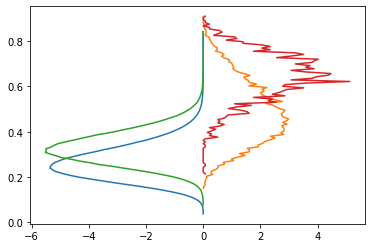

In [20]:
x = plt.hist(scores[targets == 0], bins = 100, density=True)
y = plt.hist(scores[targets == 1], bins = 100, density=True)
plt.close()

x1 = plt.hist(mt_scores[mt_targets == 0], bins = 100, density=True)
y1 = plt.hist(mt_scores[mt_targets == 1], bins = 100, density=True)
plt.close()

plt.plot(-1 * x[0], x[1][1:])
plt.plot(y[0], y[1][1:])

plt.plot(-1 * x1[0], x1[1][1:])
plt.plot(y1[0], y1[1][1:])

Text(0.5, 1.0, 'GMR @ 0.001 FMR 32.12%')

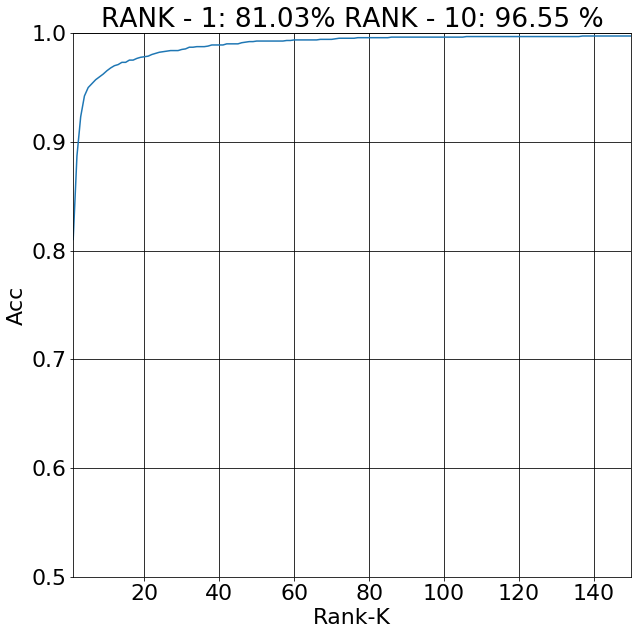

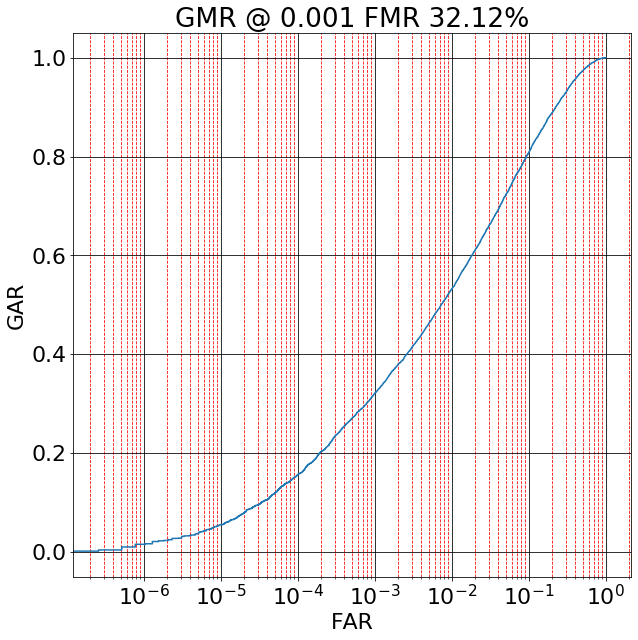

In [21]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(10, 10))
plt.plot(np.arange(1, 151), cmc_50/count)
plt.xlim([1, 150])
plt.ylim([0.50, 1.00])
plt.xlabel('Rank-K')
plt.ylabel('Acc')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.title('RANK - 1: ' + '{0:0.2f}'.format(cmc_50[0] * 100/count) + '% RANK - 10: ' + '{0:0.2f}'.format(cmc_50[9] * 100/count) + ' %')
        
plt.figure(figsize=(10, 10))
far, tar, _ = roc_curve(targets, scores)
plt.semilogx(far, tar)
plt.xlabel('FAR')
plt.ylabel('GAR')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='r', linestyle='--')
plt.title('GMR @ 0.001 FMR ' + '{0:0.2f}'.format(np.min(tar[far>= 0.001] * 100)) + '%')

Text(0.5, 1.0, 'GMR @ 0.001 FMR 69.02%')

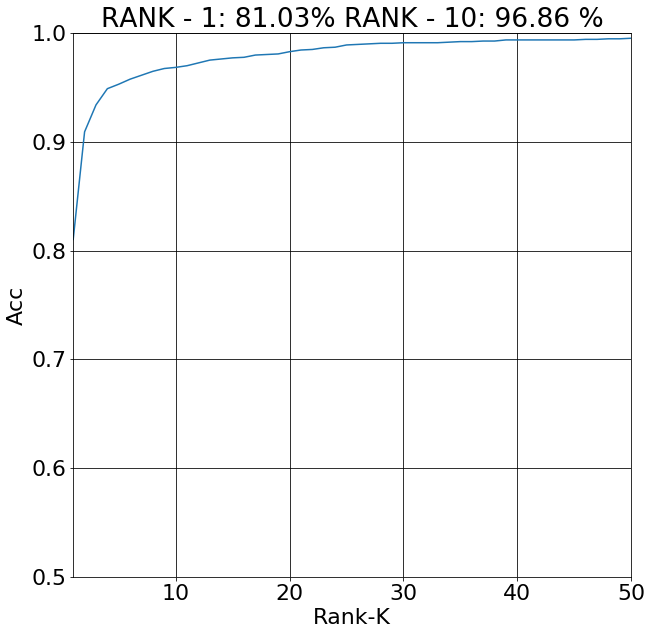

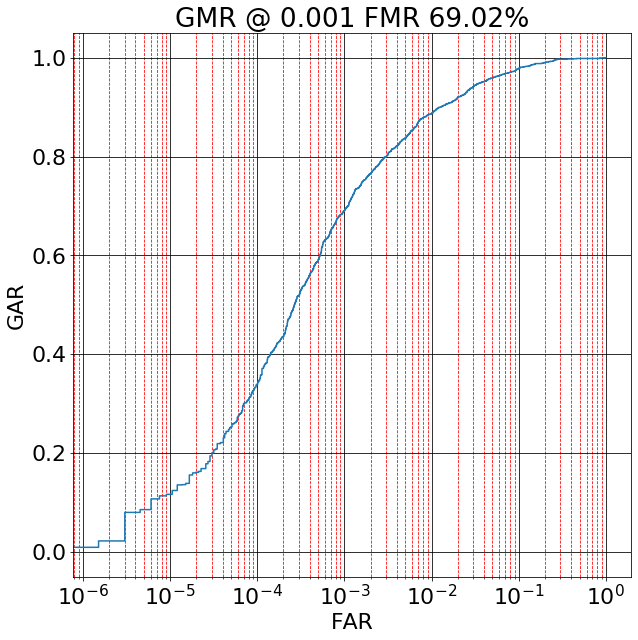

In [22]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(10, 10))
plt.plot(np.arange(1, 51), mt_cmc_50/mt_count)
plt.xlim([1, 50])
plt.ylim([0.50, 1.00])
plt.xlabel('Rank-K')
plt.ylabel('Acc')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.title('RANK - 1: ' + '{0:0.2f}'.format(mt_cmc_50[0] * 100/mt_count) + '% RANK - 10: ' + '{0:0.2f}'.format(mt_cmc_50[9] * 100/mt_count) + ' %')
        
plt.figure(figsize=(10, 10))
far, tar, _ = roc_curve(mt_targets, mt_scores)
plt.semilogx(far, tar)
plt.xlabel('FAR')
plt.ylabel('GAR')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='r', linestyle='--')
plt.title('GMR @ 0.001 FMR ' + '{0:0.2f}'.format(np.min(tar[far>= 0.001] * 100)) + '%')

In [23]:
fpr = 1 - tar
EER = fpr[np.nanargmin(np.absolute((far - fpr)))]

In [24]:
EER

0.04432989690721645

In [58]:
from glob import glob

In [61]:
imgs = glob('/home/narsi/Downloads/test/*.png')
x = []
for img in imgs:
    x.append(Image.open(img))
x[0].save("/home/narsi/Downloads/test.gif", save_all=True, append_images=x[1:], duration=1000, loop=0)

In [64]:
from moviepy.editor import *

In [66]:
clips = [ImageClip(m).set_duration(2)
      for m in imgs]

concat_clip = concatenate_videoclips(clips, method="compose")
concat_clip.write_videofile("/home/narsi/Downloads/test.mp4", fps=2)

[MoviePy] >>>> Building video /home/narsi/Downloads/test.mp4
[MoviePy] Writing video /home/narsi/Downloads/test.mp4


 94%|█████████▍| 16/17 [00:00<00:00, 88.76it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /home/narsi/Downloads/test.mp4 



In [67]:
imgs

['/home/narsi/Downloads/test/4.png',
 '/home/narsi/Downloads/test/2.png',
 '/home/narsi/Downloads/test/1.png',
 '/home/narsi/Downloads/test/3.png']